In [1]:
# for optimization
import scipy as sp
from scipy import linalg
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# fastmri
import fastmri
from fastmri.data import subsample
from fastmri.data import transforms, mri_data

# other
import h5py
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = 'cuda'

In [2]:
# Get filenames from folder
mc_path = "/media/hdd1/fastMRIdata/brain/multicoil_train/"  # multicoil data (from)
sc_path = "/root/workspace/singlecoil_train/" # singlecoil data path (save to)
filenames = []
for file in os.listdir(mc_path):
    if file.endswith(".h5"):
        filenames.append(file)

In [ ]:
# Emulate single coil data
loss_curves = []
for i in tqdm(range(0, len(filenames))):

    ######################
    ##--Get file
    #####################
    fname = filenames[i]
    path = os.path.join(mc_path, fname)
    hf = h5py.File(path, mode='r')

    #####################
    ##--Prepare data
    #####################
    volume_kspace = hf['kspace'][()]
    volume_kspace = transforms.to_tensor(volume_kspace)

    rss = hf['reconstruction_rss'][()]

    coils = volume_kspace.shape[1]
    slices, height, width = rss.shape

    coil_images_full =  fastmri.ifft2c(volume_kspace)
    coil_images = transforms.complex_center_crop(coil_images_full, (height, width)).permute(1,0,2,3,4)
    coil_images = transforms.tensor_to_complex_np(coil_images)

    ##########################################
    ##--Linear least-square initialization
    ##########################################
    A = coil_images.reshape(coils, slices*height*width).T
    b = rss.reshape(slices*height*width)
    init = linalg.lstsq(A, b)

    ##########################################
    ##--Non-linear Least-square solution
    ##########################################
    A = torch.tensor(A).to(device) 
    b = torch.tensor(b).to(device)

    x = torch.tensor(init[0], requires_grad = True, device=device) # coil-weights

    def obj_fun(x):
        return torch.sum( ( (A@x).abs().sqrt()-b.abs().sqrt() )**2 )

    # optimizer = optim.AdamW([x], lr=0.0, weight_decay=0.04)
    optimizer = optim.SGD([x], lr=0.0, momentum=0.9)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 0.05, total_steps=3000)

    loss_hist = []
    for _ in range(3000):
        optimizer.zero_grad()
        loss = obj_fun(x)
        loss.backward()
        nn.utils.clip_grad_norm_(x, max_norm=1, norm_type=2.)
        optimizer.step()
        scheduler.step()

        loss_hist.append(loss.item())
        
    loss_curves.append(loss_hist)
    # print(loss.item())
    # plt.plot(loss_hist)
    # plt.show()

    ##########################################
    ##--Create emulated single coil data
    ##########################################
    with torch.no_grad():
        # Linear combination of coil images
        xhat = x.view(1, coils, 1, 1).cpu().numpy()
        coil_images_full = transforms.tensor_to_complex_np(coil_images_full)
        single_coil_images = np.sum(coil_images_full * xhat, axis=1)
        single_coil_images = transforms.to_tensor(single_coil_images)

        # Volume single coil k-space
        single_coil_kspace = fastmri.fft2c(single_coil_images)    
        single_coil_kspace = transforms.tensor_to_complex_np(single_coil_kspace)

        # Volume single coil reconstruction
        esc = transforms.complex_center_crop(single_coil_images, (height, width))
        esc = np.abs(transforms.tensor_to_complex_np(esc)) 

    #     esc = (A@x).reshape(slices,height, width).abs().cpu().numpy()    # Also valid

        maxval = np.max(esc).astype(np.float64)
        normval = linalg.norm(esc).astype(np.float64)

    ##########################################    
    ##--Create and save as .h5 file
    ##########################################
    with h5py.File(os.path.join(sc_path, fname), "w") as f:
        f.create_dataset('ismrmrd_header', data=hf['ismrmrd_header'][()])
        f.create_dataset('kspace', data=single_coil_kspace)
        f.create_dataset('reconstruction_esc', data=esc)
        f.create_dataset('reconstruction_rss', data=hf['reconstruction_rss'][()])
        f.attrs.__setitem__('acquisition', hf.attrs.__getitem__('acquisition'))
        f.attrs.__setitem__('max', maxval)
        f.attrs.__setitem__('norm', normval)
        f.attrs.__setitem__('patient_id', hf.attrs.__getitem__('patient_id'))    

        f.close()    

torch.save(loss_curves, './loss_curves.pt')

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.0002675850410014391, 'norm': 0.09161251783370972, 'patient_id': 'ce961206b6f8f8ccee820a43bc407f742be2c538cfaa7d33abbb5d7e3d0c015d'}


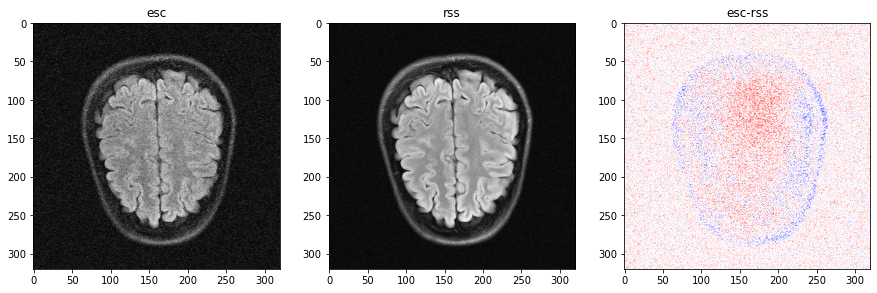

In [3]:
# Check for one sample
file_name = '/root/workspace/singlecoil_train/file_brain_AXFLAIR_200_6002549.h5'
hf = h5py.File(file_name, mode='r')
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))
esc = hf['reconstruction_esc'][()]
rss = hf['reconstruction_rss'][()]

idx = 8
fig= plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(esc[idx], cmap='gray')
plt.title('esc')
plt.subplot(1,3,2)
plt.imshow(rss[idx], cmap='gray')
plt.title('rss')
plt.subplot(1,3,3)
# plt.imshow(esc[idx]-rss[idx], cmap='bwr')
plt.imshow(esc[idx]-rss[idx], cmap='bwr')
plt.title('esc-rss')
plt.show()
